# Solve TSP problem with Genetic algorithm 
*SamanArzaghi_610398096*

## Importing libraries
First we are going to import some libraries which we may need later...

In [1]:
# importing some libraries which may we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import operator
import math

## Extract data from files
### A : first test case(bayg29)
by opening file we are going to extract weights from tsp.file :

In [2]:
# open file
f = open("bayg29.tsp", "r")
txt = f.readlines()
dic_city_length = {}
current_node = 0
# choosing dimenstion
dimension = 29
# extracting weightes
for i in range(8,36):
    current_node += 1
    list_weitght = [float(idx) for idx in txt[i].split()]
    for j in range(len(list_weitght)):
        dic_city_length[current_node, j + current_node + 1] = list_weitght[j]
        dic_city_length[j + current_node + 1, current_node] = list_weitght[j]
# creat two lists for saving best routes and lengths
best_length = []
best_routes = []

## Initial population
creating 100 unique routes.

In [3]:
routes = []
while(len(routes) < 100): 
    new_route = random.sample(range(1, dimension + 1), dimension)
    # check if new route is unique or not
    if new_route not in routes:
        routes.append(new_route)

# Creating data-frame
we use pandas data-frame to access datas better

In [4]:
df = {'routes' : routes}
df = pd.DataFrame(df)
df

,routes
0,"[6, 13, 8, 16, 20, 5, 19, 15, 7, 9, 27, 11, 10..."
1,"[10, 16, 15, 19, 14, 5, 25, 6, 8, 4, 2, 20, 12..."
2,"[26, 20, 2, 21, 7, 12, 16, 13, 27, 18, 10, 9, ..."
3,"[13, 27, 16, 24, 8, 21, 3, 7, 9, 12, 22, 17, 2..."
4,"[8, 21, 2, 6, 16, 15, 11, 24, 4, 7, 29, 28, 14..."
...,...
95,"[6, 4, 23, 15, 5, 28, 11, 25, 18, 14, 10, 22, ..."
96,"[7, 4, 19, 27, 25, 3, 1, 26, 29, 18, 16, 13, 9..."
97,"[3, 23, 27, 2, 26, 12, 19, 5, 15, 16, 21, 25, ..."
98,"[16, 18, 3, 24, 5, 17, 19, 11, 21, 12, 28, 20,..."


# Calculate fitness
with this function we can calculate a whole cycle length of a rout.

**NOTE** : because shorter length is better in this position, we move length between 0 and 1. 
(divide 1 by length)

In [5]:
def calculate_fitness(route):
    '''
        route --> a single route ( type : list )
    '''
    distance = 0
    for i in range(len(route) - 1):
        distance += dic_city_length[route[i], route[i + 1]]
    # from last node to first node
    distance += dic_city_length[route[0], route[-1]]
    fitness = 1 / float(distance)
    return fitness 

# Selection
by evaluate function we will chose most talented route to survive.

**NOTE** : both competitive methods and the survival of the fittest have been tried and the second method has obtained better results.

In [6]:
def evaluate(df, num_chosens):
    '''
        df --> data-frame of routes ( type : pandas-df )
        num_chosens --> survival rate ( type : int )
    '''
    # In the comment below, I implemented a competitive method and DID NOT get a good result
    '''
    for i in range(len(df)):
        df.loc[i, 'fitness'] = calculate_fitness(df.loc[i, 'routes'])   
    column = df["fitness"]
    max_index = column.idxmax()
    best_length.append(1 / df.loc[max_index, 'fitness'])
    best_routes.append(df.loc[max_index, 'routes'])
    sums = df['fitness'].sum()
    for i in range(len(df)):
        df.loc[i, 'prob_choosing'] = df.loc[i, 'fitness'] / sums
    probe_of_routes = list(df['prob_choosing'])
    routes_list = list(range(0, len(df)))
    accepted_routes = []
    while(len(accepted_routes) != num_chosens):
        accepted_one = random.choices(routes_list, weights = probe_of_routes, k = 1)[0]
        if(accepted_one not in accepted_routes):
            accepted_routes.append(accepted_one)
    for i in range(len(accepted_routes)):
        accepted_routes[i] = df.loc[accepted_routes[i], 'routes']
    df = pd.DataFrame({'routes' : accepted_routes})
    '''
    # calculating fitness for each route
    for i in range(len(df)):
        df.loc[i, 'fitness'] = calculate_fitness(df.loc[i, 'routes']) 
    # sorting by fitness
    df = df.sort_values(by=['fitness'], ascending=False)
    df = df.reset_index()
    # save best route and it's length
    best_length.append(1 / df.loc[0, 'fitness'])
    best_routes.append(df.loc[0, 'routes'])
    accepted_routes = []
    # convert new generation to data-frame
    for i in range(num_chosens):
        accepted_routes.append(df.loc[i, 'routes'])
    df = pd.DataFrame({'routes' : accepted_routes})
    return df

# Creating mutation functions
i decided not to use just one mutation function, but to use several mutation functions and use them all (hybrid mutation).

in the next cell, we construct four different mutation functions (swap, inversion, RGIBNNM, and IRGIBNNM, respectively).

In [7]:
# make swap mutation
def swap_mutation(route):
    '''
        route --> a single route ( type : list )
    '''
    # choose two randome cities
    first_gen, second_gen = random.sample(range(len(route)), 2)
    # change their places
    route[first_gen], route[second_gen] = route[second_gen], route[first_gen]
    return route

In [8]:
# make inversion mutation
def inversion_mutation(route):
    '''
        route --> a single route ( type : list )
    '''
    # choose two random cities
    first_gen, second_gen = random.sample(range(len(route)), 2)
    if(first_gen > second_gen):
        first_gen, second_gen = second_gen, first_gen
    sub_set = route[first_gen + 1 : second_gen]
    # inverse the sub set between two random cities
    sub_set = sub_set[::-1]
    route[first_gen + 1 : second_gen] = sub_set
    return route

In [9]:
# make RGIBNNM mutation
def RGIBNNM_mutation(route):
    '''
        route --> a single route ( type : list )
    '''
    # choose one randome city
    first_gen = random.sample(range(len(route)), 1)[0]
    # finde the closes city to random city
    most_close = float("inf")
    for i in range(len(route)):
        if(i != first_gen):
            if(dic_city_length[route[first_gen], route[i]] < most_close):
                most_close = dic_city_length[route[first_gen], route[i]]
                second_gen = i
    # move the random city before closest that we found and shift others
    temp_number = route[first_gen]
    temp_number_2 = route[second_gen]
    route.remove(temp_number)
    route.insert(route.index(temp_number_2), temp_number)
    return route

In [10]:
# make IRGIBNNM mutation
def IRGIBNNM_mutation(route):
    '''
        route --> a single route ( type : list )
    '''
    # apply inversion mutation first
    route = inversion_mutation(route)
    # choose a random city
    first_gen = random.sample(range(len(route)), 1)[0]
    # find the closest city to random city
    most_close = float("inf")
    for i in range(len(route)):
        if(i != first_gen):
            if(dic_city_length[route[first_gen], route[i]] < most_close):
                most_close = dic_city_length[route[first_gen], route[i]]
                second_gen = i
    # find the closest five cities to second city
    neiber_second_gen = []
    for i in range(len(route)):
        if(i != second_gen):
            neiber_second_gen.append([route[i], dic_city_length[route[second_gen], route[i]]])
    neiber_second_gen = sorted(neiber_second_gen, key = lambda x: x[1])
    temp_number = route[first_gen]
    # randomly choose one of five citys that we found
    while(True):
        random_gen = random.sample(range(5), 1)[0]
        if(neiber_second_gen[random_gen][0] != temp_number):
            temp_number_2 = neiber_second_gen[random_gen][0]
            break
    # move first random city before third city we choose and shift other ones
    route.remove(temp_number)
    route.insert(route.index(temp_number_2), temp_number)
    return route

# Make new generation( apply mutation function)
with the below code we are going to apply mutation function on all routes and twice the population.

how we do it?!

it's easy : we apply for mutation functions on every single route and choose the best mutation that have made, check it if it's unique, and then add it to data-frame.

**Note :** if you noticed, we did not do any cross over... because i've tried both with cross over and without cross over, and every time without cross over performed better. so, some how in TSP problem cross over does not work.

In [11]:
# make new generation
def new_generation(df):
    '''
            df --> data-frame of routes ( type : pandas-df )
    '''
    new_gen_list = []
    # apply for mutations on every single rout
    for i in list(df['routes']):
        mutation_list = []
        test =  i.copy()
        swap_mut = swap_mutation(test)
        mutation_list.append([swap_mut, calculate_fitness(swap_mut)])
        test =  i.copy()
        inversion_mut = inversion_mutation(test)
        mutation_list.append([inversion_mut, calculate_fitness(inversion_mut)])
        test =  i.copy()
        RGIBNNM_mut = RGIBNNM_mutation(test)
        mutation_list.append([RGIBNNM_mut, calculate_fitness(RGIBNNM_mut)])
        test =  i.copy()
        IRGIBNNM_mut = IRGIBNNM_mutation(test)
        mutation_list.append([IRGIBNNM_mut, calculate_fitness(IRGIBNNM_mut)])
        mutation_list = sorted(mutation_list, key = lambda x: x[1],reverse=True)
        # choose the best one
        for i in mutation_list:
            if(i not in list(df['routes'])):
                new_gen_list.append(i[0])
                break
    total_list = list(df['routes']) + new_gen_list
    df = pd.DataFrame({'routes' : total_list})
    return df

# when all is said and done :))
in the final step, we put everything together.

In [12]:
def ga_tsp(df, num_chosens, epoch):
    '''
            df --> data-frame of routes ( type : pandas-df )
            num_chosens --> survival rate ( type : int )
            epoch -->  the number of passes of the entire population ( type : int )
    '''
    for i in range(epoch):
        # creat new generation
        df = new_generation(df)
        # eliminate weaks
        df = evaluate(df, num_chosens)

# first test case(bayg29)
we have all data ready at the beginning.

we have 100 initialize population, 100 epochs, crossover = 0%, mutation = 100%, and 100 number of survivor

In [13]:
ga_tsp(df, 100, 100)

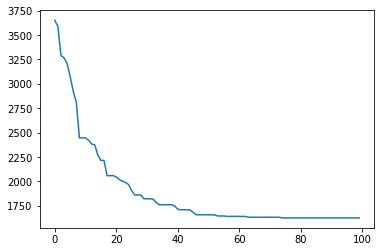

In [14]:
plt.plot(range(100), best_length)
plt.show()

we can see after 40 epochs, the data converged

now let's see best route and its length...

In [15]:
length_bayg29 = best_length[-1]
route_bayg29 = best_routes[-1]
print(length_bayg29)
print(route_bayg29)

1626.0
[5, 29, 3, 26, 9, 12, 6, 28, 1, 24, 8, 27, 23, 7, 25, 11, 22, 17, 14, 18, 15, 4, 19, 16, 13, 10, 20, 2, 21]


# Second test case(gr229)
first, let's get extract data from file

In [16]:
f = open("gr229.tsp", "r")
txt = f.readlines()
dic_city_location = {}
dic_city_length = {}
for i in range(len(txt)):
    if 'DIMENSION' in txt[i]:
        dimension = [int(s) for s in txt[i].split() if s.isdigit()][0]
    if 'NODE_COORD_SECTION' in txt[i]:
        for j in range(i + 1, i + 1 + dimension):
            city_location = [float(idx) for idx in txt[j].split()]
            dic_city_location[city_location[0]] = city_location[1], city_location[2]        
for i in range(1, len(dic_city_location)):
    for j in range(1, len(dic_city_location)):
        if(j >= i):
            dic_city_length[i, j + 1] = math.sqrt(pow((dic_city_location[i][0] - dic_city_location[j + 1][0]), 2) + pow((dic_city_location[i][1] - dic_city_location[j + 1][1]), 2))
            dic_city_length[j + 1, i] = math.sqrt(pow((dic_city_location[i][0] - dic_city_location[j + 1][0]), 2) + pow((dic_city_location[i][1] - dic_city_location[j + 1][1]), 2))
# creat two lists for saving best routes and lengths
best_length = []
best_routes = []

create some initialize population and data-frame it

In [17]:
routes = []
while(len(routes) < 100): 
    new_route = random.sample(range(1, dimension + 1), dimension)
    # check if new route is unique or not
    if new_route not in routes:
        routes.append(new_route)
df = {'routes' : routes}
df = pd.DataFrame(df)
df

,routes
0,"[181, 43, 81, 89, 168, 110, 124, 34, 169, 228,..."
1,"[22, 123, 53, 20, 206, 111, 102, 1, 79, 66, 36..."
2,"[19, 132, 18, 130, 72, 87, 128, 186, 9, 173, 1..."
3,"[199, 118, 195, 165, 196, 70, 175, 201, 124, 1..."
4,"[167, 226, 55, 100, 116, 21, 213, 50, 155, 7, ..."
...,...
95,"[74, 131, 193, 66, 120, 125, 216, 174, 34, 147..."
96,"[147, 18, 111, 90, 93, 99, 146, 49, 125, 106, ..."
97,"[184, 106, 176, 112, 185, 25, 57, 192, 199, 95..."
98,"[167, 164, 67, 206, 76, 183, 83, 182, 171, 187..."


for this case, we have 100 initialize population, 2000 epochs, crossover = 0%, mutation = 100%, and 100 number of survivor

In [18]:
ga_tsp(df, 100, 2000)

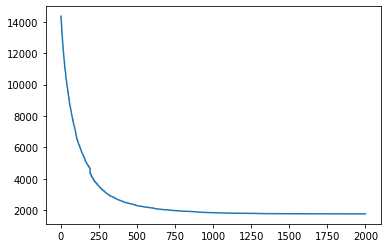

In [19]:
plt.plot(range(2000), best_length)
plt.show()

we can see after 1000 epochs, the data converged

now let's see best route and its length...

In [20]:
length_gr229 = best_length[-1]
route_gr229 = best_routes[-1]
print(length_gr229)
print(route_gr229)

1766.3385912297
[25, 84, 24, 23, 56, 57, 55, 54, 58, 53, 52, 51, 19, 11, 10, 18, 17, 12, 16, 20, 21, 22, 30, 33, 34, 38, 31, 32, 29, 28, 27, 26, 15, 14, 13, 2, 1, 3, 4, 5, 7, 8, 9, 6, 224, 225, 218, 217, 227, 226, 228, 229, 68, 69, 67, 63, 66, 65, 64, 62, 61, 60, 59, 83, 82, 81, 87, 85, 86, 89, 88, 80, 79, 78, 70, 71, 72, 73, 76, 77, 90, 91, 75, 74, 103, 102, 101, 100, 94, 93, 92, 36, 35, 37, 95, 96, 99, 98, 97, 104, 105, 107, 106, 112, 115, 118, 119, 121, 122, 123, 120, 116, 113, 117, 114, 111, 126, 127, 128, 129, 130, 171, 133, 131, 132, 138, 139, 142, 140, 141, 143, 144, 145, 146, 147, 148, 149, 151, 154, 155, 150, 204, 158, 157, 156, 159, 160, 161, 162, 153, 152, 136, 137, 134, 135, 172, 163, 164, 165, 173, 176, 175, 174, 170, 169, 168, 177, 179, 181, 180, 178, 182, 183, 185, 186, 187, 197, 198, 199, 200, 201, 202, 203, 211, 212, 205, 206, 207, 208, 209, 210, 213, 214, 215, 216, 219, 220, 221, 222, 223, 191, 192, 195, 196, 194, 193, 190, 189, 188, 48, 47, 49, 44, 43, 45, 42, 46, 50

# Third test case(pr1002)
first, let's get extract data from file

In [21]:
f = open("pr1002.tsp", "r")
txt = f.readlines()
dic_city_location = {}
dic_city_length = {}
for i in range(len(txt)):
    if 'DIMENSION' in txt[i]:
        dimension = [int(s) for s in txt[i].split() if s.isdigit()][0]
    if 'NODE_COORD_SECTION' in txt[i]:
        for j in range(i + 1, i + 1 + dimension):
            city_location = [float(idx) for idx in txt[j].split()]
            dic_city_location[city_location[0]] = city_location[1], city_location[2]        
for i in range(1, len(dic_city_location)):
    for j in range(1, len(dic_city_location)):
        if(j >= i):
            dic_city_length[i, j + 1] = math.sqrt(pow((dic_city_location[i][0] - dic_city_location[j + 1][0]), 2) + pow((dic_city_location[i][1] - dic_city_location[j + 1][1]), 2))
            dic_city_length[j + 1, i] = math.sqrt(pow((dic_city_location[i][0] - dic_city_location[j + 1][0]), 2) + pow((dic_city_location[i][1] - dic_city_location[j + 1][1]), 2))
# creat two lists for saving best routes and lengths
best_length = []
best_routes = []

create some initialize population and data-frame it.

In [22]:
routes = []
while(len(routes) < 100): 
    new_route = random.sample(range(1, dimension + 1), dimension)
    # check if new route is unique or not
    if new_route not in routes:
        routes.append(new_route)
df = {'routes' : routes}
df = pd.DataFrame(df)
df

,routes
0,"[35, 573, 790, 55, 124, 455, 739, 235, 144, 34..."
1,"[478, 134, 536, 68, 53, 832, 971, 908, 578, 97..."
2,"[117, 423, 682, 33, 372, 791, 357, 686, 756, 9..."
3,"[59, 874, 396, 633, 71, 425, 456, 755, 384, 64..."
4,"[282, 535, 308, 144, 435, 268, 851, 161, 827, ..."
...,...
95,"[167, 579, 893, 792, 388, 134, 300, 153, 617, ..."
96,"[440, 153, 525, 953, 987, 238, 667, 165, 202, ..."
97,"[461, 341, 671, 992, 577, 545, 731, 679, 297, ..."
98,"[940, 575, 524, 862, 72, 313, 771, 593, 288, 5..."


for this case, we have 100 initialize population, 20000 epochs, crossover = 0%, mutation = 100%, and 100 number of survivor

In [23]:
ga_tsp(df, 100, 20000)

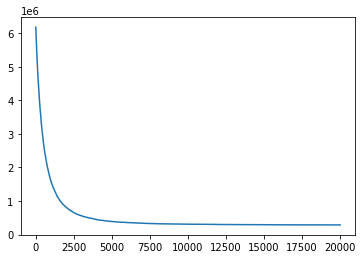

In [24]:
plt.plot(range(20000), best_length)
plt.show()

we can see after 10000 epochs, the data converged(the Y axis is a single digit because the list of numbers has been very large)

now let's see best route and its length...

In [25]:
length_pr1002 = best_length[-1]
route_pr1002 = best_routes[-1]
print(length_pr1002)
print(route_pr1002)

286603.6453676496
[579, 580, 578, 577, 576, 575, 573, 572, 574, 588, 589, 590, 594, 593, 595, 596, 597, 599, 598, 600, 601, 797, 796, 795, 794, 793, 789, 790, 791, 792, 732, 731, 730, 736, 737, 708, 709, 713, 710, 711, 712, 723, 728, 729, 727, 724, 725, 726, 663, 664, 665, 668, 667, 666, 670, 669, 672, 671, 674, 677, 675, 676, 682, 681, 680, 679, 678, 673, 719, 718, 720, 722, 714, 715, 721, 717, 716, 695, 694, 696, 707, 706, 697, 705, 698, 699, 700, 701, 969, 972, 971, 970, 693, 692, 691, 690, 689, 688, 687, 686, 685, 683, 684, 988, 989, 990, 984, 983, 985, 986, 987, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 968, 967, 966, 965, 964, 963, 702, 703, 704, 740, 739, 738, 735, 734, 744, 745, 742, 741, 743, 747, 748, 746, 733, 749, 750, 751, 752, 753, 754, 755, 1000, 763, 764, 765, 962, 961, 993, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944, 943, 942, 941, 940, 939, 957, 958, 959, 960, 769, 767, 766, 768, 770, 771, 772, 774, 775, 773, 935, 934, 936, 938, 937, 933, 